# Options sur devises

In [1]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Simulation de trajectoires sous la probabilité risque neutre

In [2]:
def simulate(S0, sigma, r0, r1, N, T):
    S = np.zeros(N)
    dt = T/N
    S[0] = S0
    for i in range(1, N):
        Z = np.random.normal(0, 1)
        S[i] = S[i-1] + S[i-1] * (sigma * np.sqrt(dt) * Z + (r0-r1) * dt)
    return S

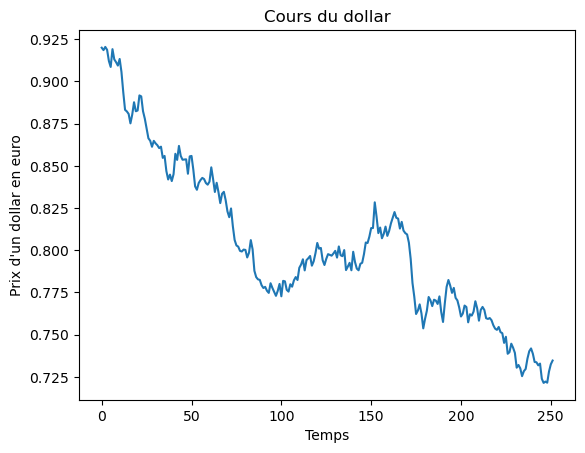

In [3]:
# Paramètres
S0 = 0.92
sigma = 0.1
r0 = 0.1
r1 = 0.07
N = 252
T = 1
K = 0.89

# Simulation
S = simulate(S0, sigma, r0, r1, N, T)

# Affichage
plt.plot(S)
plt.title("Cours du dollar")
plt.xlabel("Temps")
plt.ylabel("Prix d'un dollar en euro")
plt.savefig("cours-dollar.png")
plt.show()

## Prix et Delta

In [4]:
def F(t, x, K, sigma, r0, r1, T):
    d1 = (np.log(x/K)+(r0-r1+(sigma**2/2)*(T-t)))/(sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    return x*np.exp(-r1*(T-t))*norm.cdf(d1) - K*np.exp(-r0*(T-t))*norm.cdf(d2)

def delta(t, x, K, sigma, r0, r1, T):
    d = np.log(x * np.exp(-r1*(T-t)) / (K * np.exp(-r0*(T-t)))) / (sigma*np.sqrt(T-t))
    d += sigma*np.sqrt(T-t)/2
    return np.exp(-r1*(T-t)) * norm.cdf(d)

def hedging(S, N, T, K, sigma, r0, r1):
    H0 = np.zeros(N)
    H = np.zeros(N)
    for i in range(N):
        t = i*T/N
        H[i] = delta(t, S[i], K, sigma, r0, r1, T)
        H0[i] = F(t, S[i], K, sigma, r0, r1, T) - H[i]*S[i]
    return H0, H

def value(H0, H, S):
    return H0 + H * S

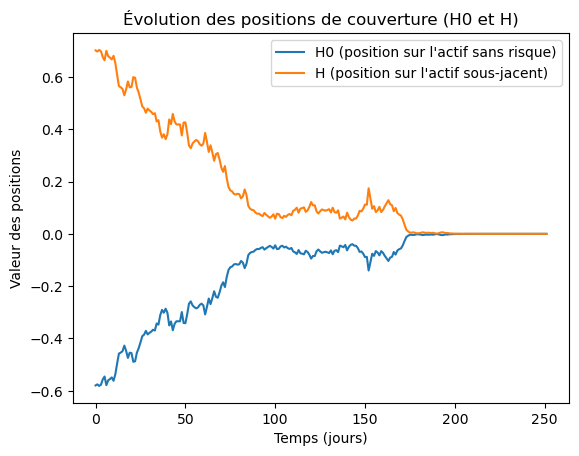

In [5]:
H0, H = hedging(S, N, T, K, sigma, r0, r1)
portfolio_value = value(H0, H, S)

# Valeur réelle de l’option à chaque date
F_real = np.array([F(i*T/N, S[i], K, sigma, r0, r1, T) for i in range(N)])

# Tracé de H0 et H
plt.plot(H0, label="H0 (position sur l'actif sans risque)")
plt.plot(H, label="H (position sur l'actif sous-jacent)")
plt.title("Évolution des positions de couverture (H0 et H)")
plt.xlabel("Temps (jours)")
plt.ylabel("Valeur des positions")
plt.legend()
plt.savefig("positions-couverture.png")
plt.show()

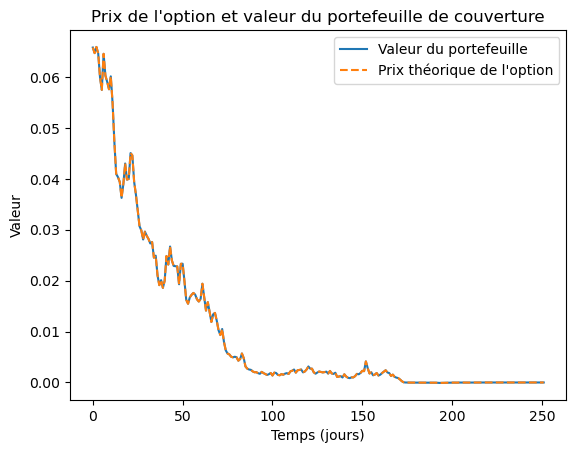

In [6]:
# Affichage
plt.plot(portfolio_value, label="Valeur du portefeuille")
plt.plot(F_real, linestyle='--', label="Prix théorique de l'option")
plt.title("Prix de l'option et valeur du portefeuille de couverture")
plt.xlabel("Temps (jours)")
plt.ylabel("Valeur")
plt.legend()
plt.savefig("valeur-couverture-option.png")
plt.show()

## Exercice de couverture

In [78]:
def monte_carlo(S0, sigma, mu, N, T, K, n=10000):
    values = []
    eps = 0.001
    for _ in range(n):
        S = simulate(S0, sigma, mu, 0, N, T)[-1]
        H = delta(T-eps, S, K, sigma, mu, 0, T)
        H0 = F(T-eps, S, K, sigma, mu, 0, T) - H*S
        V = H0 + H*S
        payoff = max(S-K, 0)
        values.append((V-payoff)**2)
    return np.mean(values)

In [93]:
# Paramètres
S0 = 0.92
sigma = 0.1
N = 252
T = 1
K = 0.89
n = 1000
N_values = list(range(2, 1001, 50))  # ou moins si besoin pour aller plus vite

In [95]:
mu1 = 0.05
errors1 = [monte_carlo(S0, sigma, mu1, N, T, K, n) for N in N_values]

mu2 = 0.15
errors2 = [monte_carlo(S0, sigma, mu2, N, T, K, n) for N in N_values]

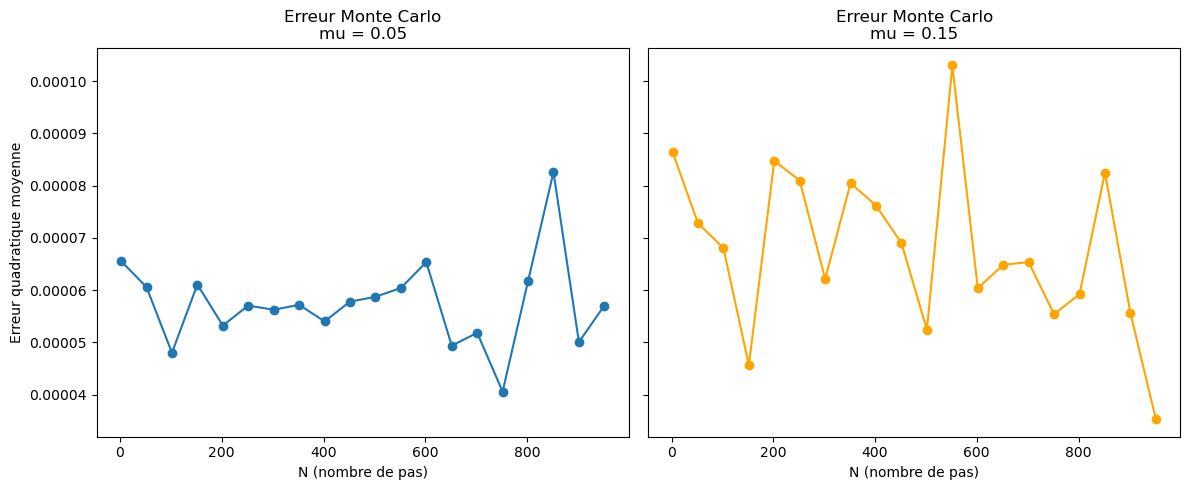

In [98]:
# Création de la figure avec deux sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Premier graphe : mu = mu1
axes[0].plot(N_values, errors1, marker='o', label=f"mu = {mu1}")
axes[0].set_title(f"Erreur Monte Carlo\nmu = {mu1}")
axes[0].set_xlabel("N (nombre de pas)")
axes[0].set_ylabel("Erreur quadratique moyenne")

# Deuxième graphe : mu = mu2
axes[1].plot(N_values, errors2, marker='o', label=f"mu = {mu2}", color='orange')
axes[1].set_title(f"Erreur Monte Carlo\nmu = {mu2}")
axes[1].set_xlabel("N (nombre de pas)")

plt.savefig("erreur.png")
plt.tight_layout()
plt.show()

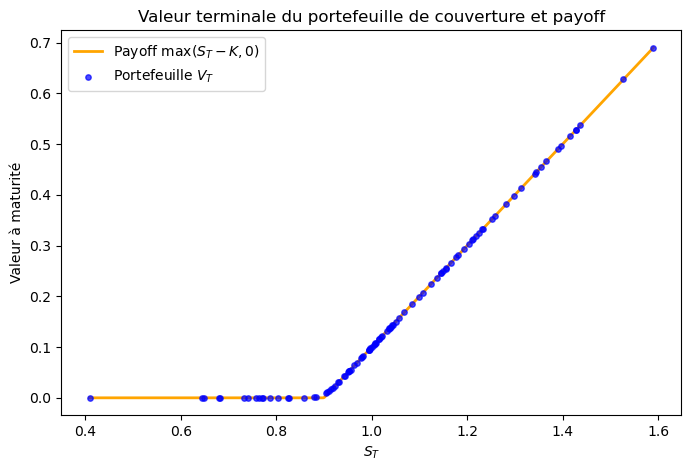

In [101]:
# Générer les points (ST, VT) et (ST, payoff)
def simulate_ST_VT(S0, sigma, mu, N, T, K, n):
    ST_list = []
    VT_list = []
    payoff_list = []
    eps = 0.01
    for _ in range(n):
        S = simulate(S0, sigma, mu, 0, N, T)[-1]
        H = delta(T - eps, S, K, sigma, 0, 0, T)
        H0 = F(T - eps, S, K, sigma, 0, 0, T) - H * S
        VT = H0 + H * S
        payoff = max(S - K, 0)
        ST_list.append(S)
        VT_list.append(VT)
        payoff_list.append(payoff)
    return ST_list, VT_list, payoff_list

# Paramètres
S0 = 1
sigma = 0.2
mu = 0.08
T = 1
K = 0.9
N = 10
n = 100

# Simulation
ST, VT, payoff = simulate_ST_VT(S0, sigma, mu, N, T, K, n)

# Payoff théorique
x = np.linspace(min(ST), max(ST), 500)
payoff_curve = np.maximum(x - K, 0)

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(x, payoff_curve, label="Payoff $\\max(S_T - K, 0)$", color='orange', linewidth=2, zorder=1)
plt.scatter(ST, VT, alpha=0.7, label="Portefeuille $V_T$", s=15, c='blue', zorder=2)
plt.xlabel("$S_T$")
plt.ylabel("Valeur à maturité")
plt.title("Valeur terminale du portefeuille de couverture et payoff")
plt.legend()
plt.savefig("exercice-couverture.png")
plt.show()